In [1]:
import numpy as np
import visualkeras as vk # pip install visualkeras
import pandas as pd
import seaborn as sn
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [4]:
train_data = np.load("../numpy/train_data.npy")
test_data = np.load("../numpy/test_data.npy")
train_labels = np.load("../numpy/train_labels.npy")
test_labels = np.load("../numpy/test_labels.npy")

In [2]:
model = Sequential()

model.add(Conv2D(128, (5, 5), input_shape=(48, 48, 1), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 32)         0

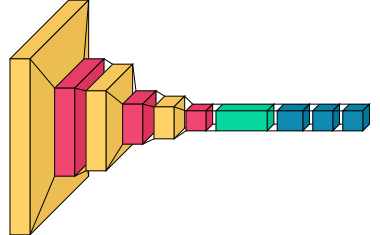

In [142]:
vk.layered_view(model)

In [143]:
datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True, 
        fill_mode="nearest"
)

In [144]:
best_loss_checkpoint = ModelCheckpoint(
    filepath="../models/best_loss_model.h5",
    monitor="loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

best_val_loss_checkpoint = ModelCheckpoint(
    filepath="../models/best_val_loss_model.h5",
    monitor="val_loss",
    save_best_only=True,
    save_weights_only=True,
    mode="min"
)

In [145]:
bs = 16

history = model.fit(
    datagen.flow(
        train_data,
        train_labels,
        batch_size=bs
    ),
    steps_per_epoch=len(train_data)//bs,
    validation_data=(test_data, test_labels),
    epochs=100,
    callbacks=[best_loss_checkpoint, best_val_loss_checkpoint]
)

Epoch 1/100
72/72 [==============================] - 9s 116ms/step - loss: 0.6904 - accuracy: 0.5389 - val_loss: 0.5622 - val_accuracy: 0.7423
Epoch 2/100
72/72 [==============================] - 10s 133ms/step - loss: 0.4828 - accuracy: 0.7677 - val_loss: 0.2220 - val_accuracy: 0.9210
Epoch 3/100
72/72 [==============================] - 10s 132ms/step - loss: 0.3683 - accuracy: 0.8550 - val_loss: 0.1698 - val_accuracy: 0.9347
Epoch 4/100
72/72 [==============================] - 10s 134ms/step - loss: 0.2354 - accuracy: 0.9092 - val_loss: 0.1236 - val_accuracy: 0.9450
Epoch 5/100
72/72 [==============================] - 9s 117ms/step - loss: 0.1852 - accuracy: 0.9310 - val_loss: 0.1241 - val_accuracy: 0.9553
Epoch 6/100
72/72 [==============================] - 9s 121ms/step - loss: 0.1667 - accuracy: 0.9432 - val_loss: 0.1028 - val_accuracy: 0.9622
Epoch 7/100
72/72 [==============================] - 8s 118ms/step - loss: 0.1380 - accuracy: 0.9493 - val_loss: 0.1108 - val_accuracy: 0.9

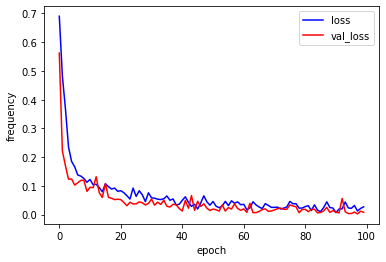

In [146]:
plt.plot(history.history["loss"], 'b', label="loss")
plt.plot(history.history["val_loss"], 'r', label="val_loss")
plt.xlabel("epoch")
plt.ylabel("frequency")
plt.legend()
plt.show()

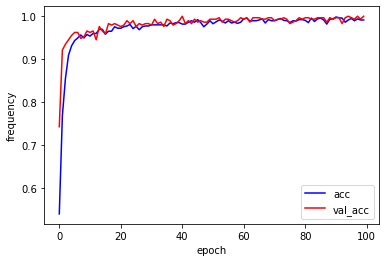

In [147]:
plt.plot(history.history["accuracy"], 'b', label="acc")
plt.plot(history.history["val_accuracy"], 'r', label="val_acc")
plt.xlabel("epoch")
plt.ylabel("frequency")
plt.legend()
plt.show()

In [3]:
model.load_weights('../models/best_val_loss_model.h5')

In [5]:
loss, acc = model.evaluate(test_data, test_labels)

loss, acc

10/10 [==============================] - 2s 52ms/step - loss: 0.0024 - accuracy: 1.0000


(0.0024374898057430983, 1.0)

In [6]:
predictions = model.predict(test_data)

In [7]:
confusion = confusion_matrix(
    np.argmax(test_labels, axis=1),
    np.argmax(predictions, axis=1)
)
print(confusion)

[[139   0]
 [  0 152]]


<AxesSubplot:xlabel='predicted', ylabel='actual'>

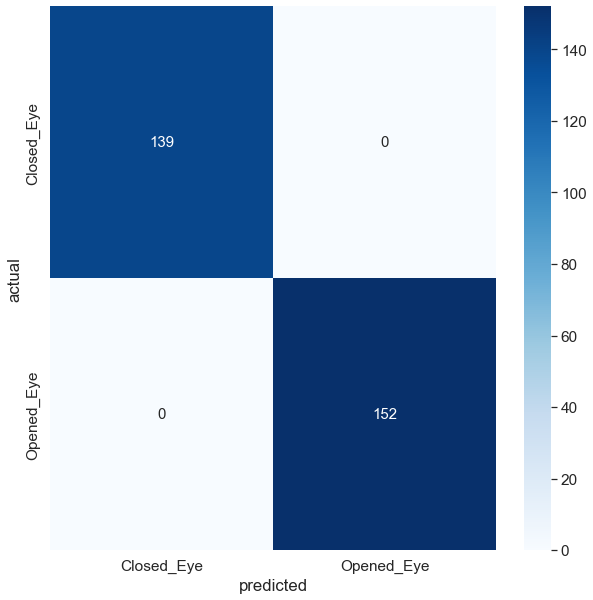

In [8]:
labels = ['Closed_Eye', 'Opened_Eye']

df_cm = pd.DataFrame(confusion, columns=np.unique(labels), index = np.unique(labels))
df_cm.index.name = 'actual'
df_cm.columns.name = 'predicted'
plt.figure(figsize = (10, 10))
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 15}, fmt="d")